In [ ]:
# dataset is @ https://finance.yahoo.com/quote/MSFT/history/

In [ ]:
import pandas as pd
import yfinance as yf

#msoft = yf.Ticker("MSFT")
df = yf.download("MSFT")
#yf.download to download this data

#df = pd.read_csv('MSFT.csv')

#df = msoft.history("max", interval = "1d")
print(df[:20])

[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400
1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400
1986-03-20  0.098090  0.098090  0.094618  0.095486   0.058876    58435200
1986-03-21  0.095486  0.097222  0.091146  0.092882   0.057270    59990400
1986-03-24  0.092882  0.092882  0.089410  0.090278   0.055665    65289600
1986-03-25  0.090278  0.092014  0.089410  0.092014   0.056735    32083200
1986-03-26  0.092014  0.095486  0.091146  0.094618   0.058341    22752000
1986-03-27  0.094618  0.096354  0.094618  0.096354   0.059411    16848000
1986-03-31  0.096354  0.096354  0.0937

In [ ]:
df = df['Close']
print(df)

Date
1986-03-13      0.097222
1986-03-14      0.100694
1986-03-17      0.102431
1986-03-18      0.099826
1986-03-19      0.098090
                 ...    
2024-09-20    435.269989
2024-09-23    433.510010
2024-09-24    429.170013
2024-09-25    432.109985
2024-09-26    431.309998
Name: Close, Length: 9713, dtype: float64


In [ ]:
#@title Turn Date Strings to Objects (Not Required)
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)

datetime_tst = str_to_datetime("1986-03-13")
datetime_tst
#df.index gives the dates and times
print(df.index)
#df.apply(str_to_datetime, 0)
#df.index = df.pop('Date')

datetime.datetime(1986, 3, 13, 0, 0)

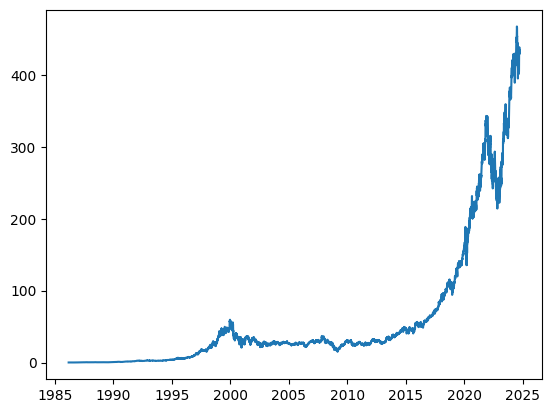

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.index, df)

In [ ]:
import numpy as np


def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  #group into sets of three precursors followed by the datapoint itself
  #arbitrary data range chosen here
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset.to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [ ]:
#@title Turn into 3D tensor X and vector y
def windowed_df_to_date_X_y(windowed_dataframe):
  #make df numpy compatible (it's a pandas feature)
  df_as_np = windowed_df.to_numpy()

  #select all rows but first col for dates
  dates = df_as_np[:, 0]

  #select middle three cols
  middle_matrix = df_as_np[:, 1:-1]
  #np reshape matrix to be len(dates) number of sets of 3 for input
  #.shape[1] is number in c of (r, c), i.e. 3
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  #final col
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
#print(X)

[[[235.99]
  [237.58]
  [235.46]]

 [[237.58]
  [235.46]
  [232.34]]

 [[235.46]
  [232.34]
  [236.48]]

 [[232.34]
  [236.48]
  [235.24]]

 [[236.48]
  [235.24]
  [231.85]]

 [[235.24]
  [231.85]
  [235.77]]

 [[231.85]
  [235.77]
  [242.35]]

 [[235.77]
  [242.35]
  [249.07]]

 [[242.35]
  [249.07]
  [247.86]]

 [[249.07]
  [247.86]
  [249.9 ]]

 [[247.86]
  [249.9 ]
  [253.25]]

 [[249.9 ]
  [253.25]
  [255.85]]

 [[253.25]
  [255.85]
  [255.91]]

 [[255.85]
  [255.91]
  [258.49]]

 [[255.91]
  [258.49]
  [255.59]]

 [[258.49]
  [255.59]
  [259.5 ]]

 [[255.59]
  [259.5 ]
  [260.74]]

 [[259.5 ]
  [260.74]
  [258.74]]

 [[260.74]
  [258.74]
  [258.26]]

 [[258.74]
  [258.26]
  [260.58]]

 [[258.26]
  [260.58]
  [257.17]]

 [[260.58]
  [257.17]
  [261.15]]

 [[257.17]
  [261.15]
  [261.55]]

 [[261.15]
  [261.55]
  [261.97]]

 [[261.55]
  [261.97]
  [254.56]]

 [[261.97]
  [254.56]
  [252.51]]

 [[254.56]
  [252.51]
  [252.18]]

 [[252.51]
  [252.18]
  [251.86]]

 [[252.18]
  [251.86

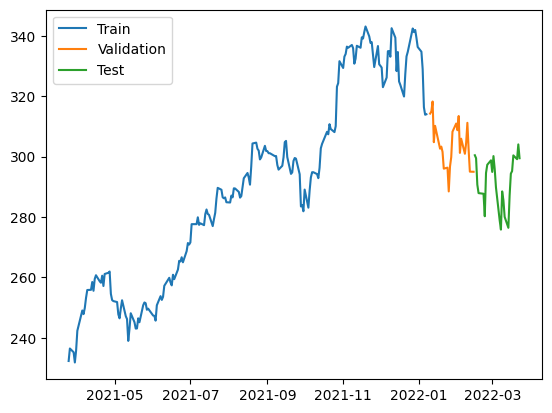

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

#train up on 80% of the data
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

#validate on 80%-90% interval of data
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
#then test on the last 10% of data
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 82787.0391 - mean_absolute_error: 285.9600 - val_loss: 92141.2422 - val_mean_absolute_error: 303.4605
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 85303.3438 - mean_absolute_error: 290.3778 - val_loss: 91831.6406 - val_mean_absolute_error: 302.9500
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83538.8672 - mean_absolute_error: 287.2095 - val_loss: 91460.1172 - val_mean_absolute_error: 302.3361
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 84164.8438 - mean_absolute_error: 288.3391 - val_loss: 91004.6406 - val_mean_absolute_error: 301.5819
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83318.4609 - mean_absolute_error: 286.9073 - val_loss: 90342.2031 - val_mean_absolute_error: 300.4816
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83992.0312 - mean_absolute_error: 288.0890 - val_loss: 89460.9375 - val_mean_absolute_error: 299.0117
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


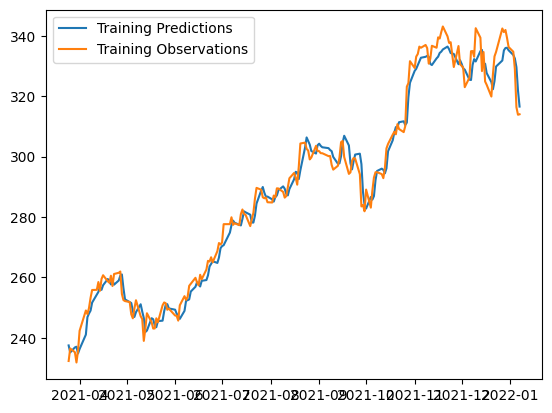

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


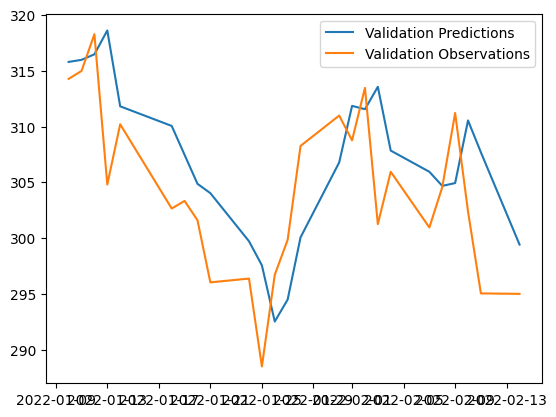

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


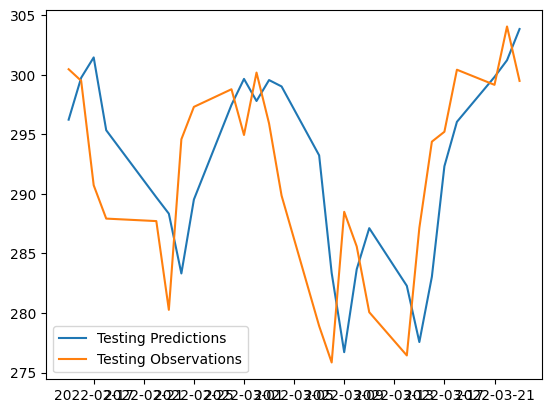

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

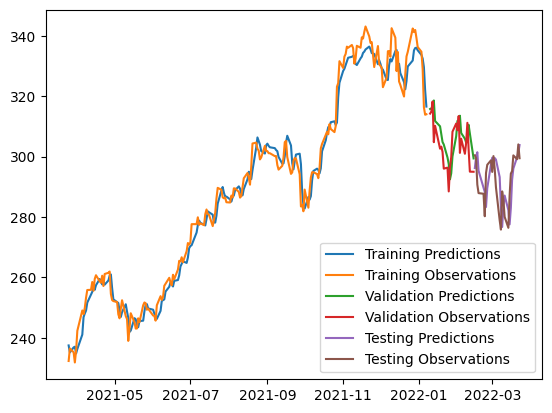

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

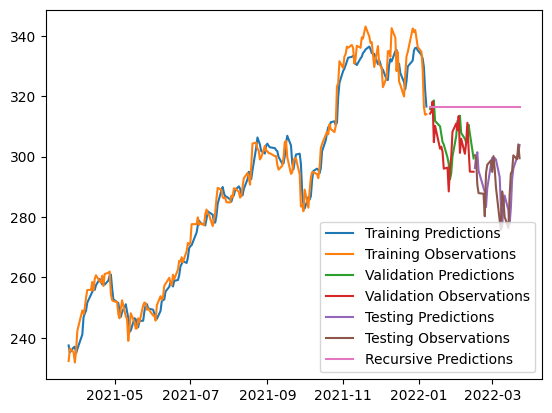

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])